<a href="https://colab.research.google.com/github/KaylumCassidy/BMCA3/blob/main/Copy_of_DATA4001FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DATA4001 Final Project Image-Based Video Game Classification with Deep Neural Networks

In this project, we aim to develop a deep learning model that can automatically classify video games into their respective games based on images or visual content. Video game genre classification is a valuable application of computer vision and deep learning, with potential uses in recommendation systems, content tagging, and more. The project will focus on leveraging deep learning techniques to accurately identify and classify video game genres from in-game screenshots or cover art.

##  Importing Libraries

In [40]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import random
import shutil

In [41]:

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
import itertools
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [42]:
pip install split-folders


In [43]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import splitfolders
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Importing data via Kaggle API

In [6]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d aditmagotra/gameplay-images


100% 2.50G/2.51G [01:52<00:00, 25.2MB/s]
100% 2.51G/2.51G [01:52<00:00, 23.9MB/s]


In [8]:
!ls /content/


gameplay-images.zip  kaggle.json  sample_data


In [ ]:
!unzip "gameplay-images.zip" -d /content/my-dataset

In [10]:
import os

# Specify the directory where your dataset is located
dataset_directory = 'my-dataset/Dataset'

# List the contents of the dataset directory
contents = os.listdir(dataset_directory)

# Print the contents
for item in contents:
    if os.path.isdir(os.path.join(dataset_directory, item)):
        print(f"Directory: {item}/")
    else:
        print(f"File: {item}")

Directory: Apex Legends/
Directory: God of War/
Directory: Minecraft/
Directory: Genshin Impact/
Directory: Fortnite/
Directory: Terraria/
Directory: Forza Horizon/
Directory: Free Fire/
Directory: Among Us/
Directory: Roblox/


## Divide our dataset into train and val

In [11]:
data_dir = 'my-dataset/Dataset'
splitfolders.ratio('my-dataset/Dataset', output=data_dir, seed=1337, ratio=(0.8, 0.2, 0))

Copying files: 10000 files [00:12, 784.20 files/s]


In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop a portion of the image and resize it to 224x224
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),  # Convert the image to a torch.FloatTensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256
        transforms.CenterCrop(224),  # Crop a 224x224 portion from the center of the image
        transforms.ToTensor(),  # Convert the image to a torch.FloatTensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Train size: {dataset_sizes['train']}")
print(f"Validation size: {dataset_sizes['val']}")
print(f"The notebook is running on {device}")


Train size: 8000
Validation size: 2000
The notebook is running on cpu


In [13]:
import glob

# Define the directory path to your gameplay data
path = 'my-dataset/Dataset'

# Use glob to list all .jpg files in the specified directory and its subdirectories
path_imgs = list(glob.glob(path + '/**/*.png', recursive=True))

# Extract labels from the file paths
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], path_imgs))

# Create a Pandas Series for file paths and labels
file_path = pd.Series(path_imgs, name='File_Path', dtype=str)
labels = pd.Series(labels, name='Labels', dtype=str)

# Create a DataFrame by concatenating the file paths and labels
data = pd.concat([file_path, labels], axis=1)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Display the first few rows of the DataFrame
data.head()

File_Path         Labels
0  my-dataset/Dataset/val/Forza Horizon/image_23.png  Forza Horizon
1    my-dataset/Dataset/train/Terraria/image_548.png       Terraria
2      my-dataset/Dataset/Apex Legends/image_740.png   Apex Legends
3      my-dataset/Dataset/val/Fortnite/image_921.png       Fortnite
4     my-dataset/Dataset/val/Minecraft/image_755.png      Minecraft

In [22]:
# Generate data paths with labels
ds_name = 'Games'
def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [23]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [38]:
df.head()

filepaths          labels
0   my-dataset/Dataset/Genshin Impact/image_69.png  Genshin Impact
1  my-dataset/Dataset/Genshin Impact/image_872.png  Genshin Impact
2  my-dataset/Dataset/Genshin Impact/image_378.png  Genshin Impact
3  my-dataset/Dataset/Genshin Impact/image_884.png  Genshin Impact
4  my-dataset/Dataset/Genshin Impact/image_116.png  Genshin Impact

## EDA & Data Visualization

In [16]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

The Games dataset has 10030 images.


In [17]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")

num_of_classes(df, ds_name)

The Games dataset has 13 classes


In [18]:
def classes_count(df, name='df'):

    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)

classes_count(df, ds_name)

The Games dataset has: 

Class 'Genshin Impact' has 1000 images
----------------------------------------------------------------------
Class 'Apex Legends' has 1000 images
----------------------------------------------------------------------
Class 'God of War' has 1000 images
----------------------------------------------------------------------
Class 'Minecraft' has 1000 images
----------------------------------------------------------------------
Class 'Terraria' has 1000 images
----------------------------------------------------------------------
Class 'Free Fire' has 1000 images
----------------------------------------------------------------------
Class 'test' has 10 images
----------------------------------------------------------------------
Class 'Among Us' has 1000 images
----------------------------------------------------------------------
Class 'Forza Horizon' has 1000 images
----------------------------------------------------------------------
Class 'Fortnite' has 1000 

In [19]:
def check_null_values(df, name='df'):

    num_null_vals = sum(df.isnull().sum().values)

    if not num_null_vals:
        print(f"The {name} dataset has no null values")

    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())


check_null_values(df, ds_name)

The Games dataset has no null values


In [24]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')

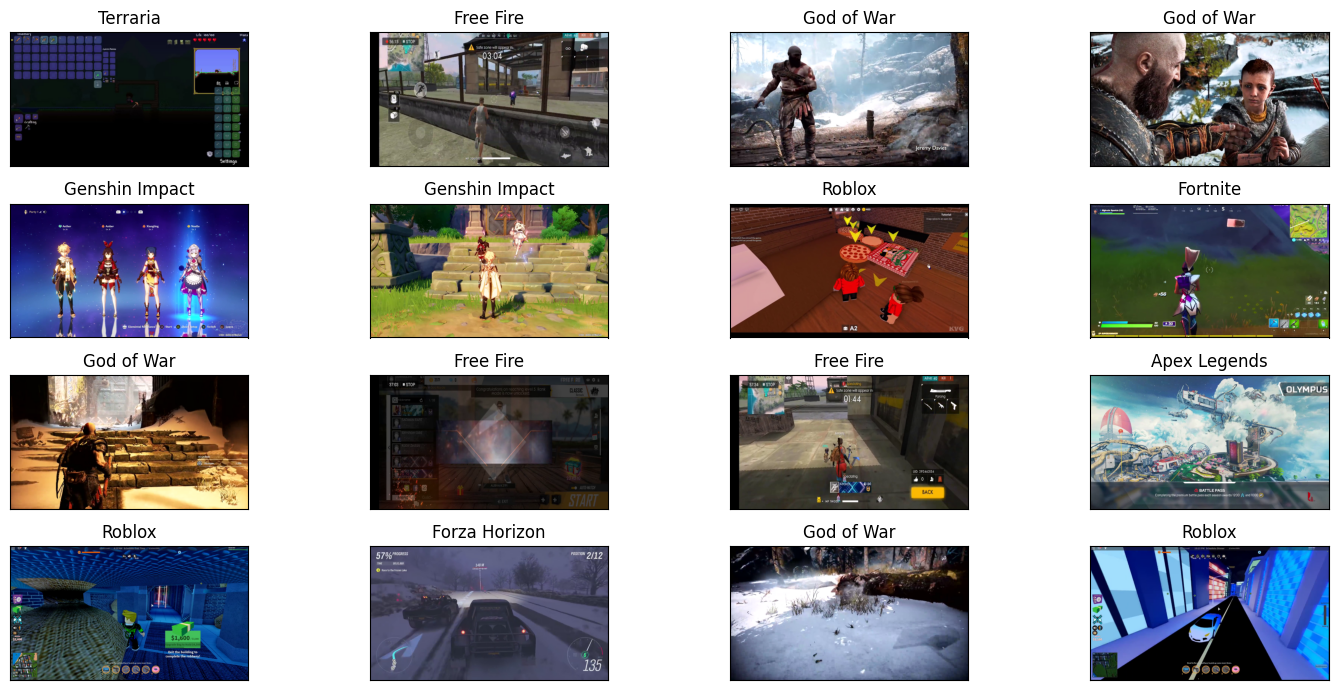

In [ ]:


# Define the number of rows and columns in the grid
nrows = 4
ncols = 4

# Create a 4x4 grid of subplots for visualization
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

# Loop through the subplots and display images with labels
for i, ax in enumerate(axes.flat):
    if i < len(data):
        # Load and display an image from the 'File_Path' and set the title as 'Labels'
        ax.imshow(plt.imread(data.File_Path[i]))  # Display the image
        ax.set_title(data.Labels[i])  # Set the title as the label
    else:
        # If there are no more images in the dataset, remove the empty subplot
        fig.delaxes(ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


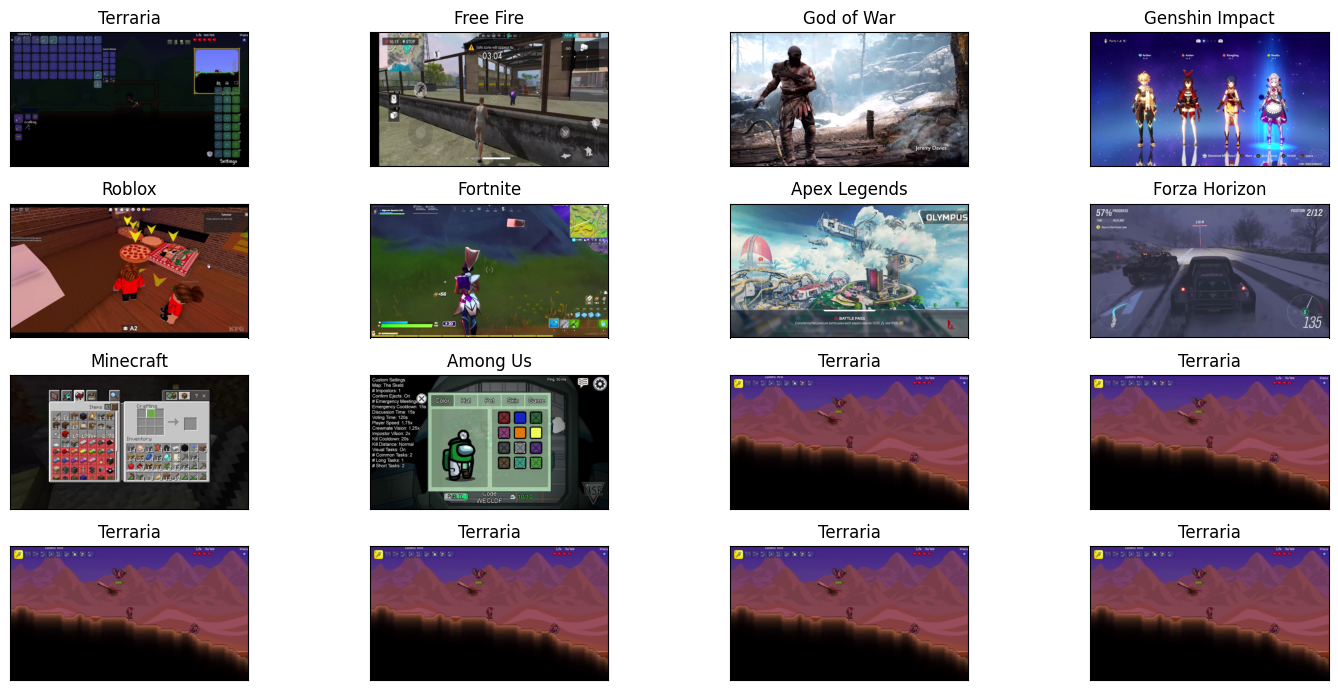

In [ ]:


# Create a list to keep track of seen game classes
seen_classes = set()

# Create a 4x4 grid of subplots for visualization
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

# Loop through the subplots and display one image from each game class
for i, ax in enumerate(axes.flat):
    # Find the next image with a new game class
    while data.Labels[i] in seen_classes and i < len(data) - 1:
        i += 1

    # Add the current game class to the set of seen classes
    seen_classes.add(data.Labels[i])

    # Load and display the selected image from the 'File_Path'
    ax.imshow(plt.imread(data.File_Path[i]))  # Display the image
    ax.set_title(data.Labels[i])  # Set the title as the label

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


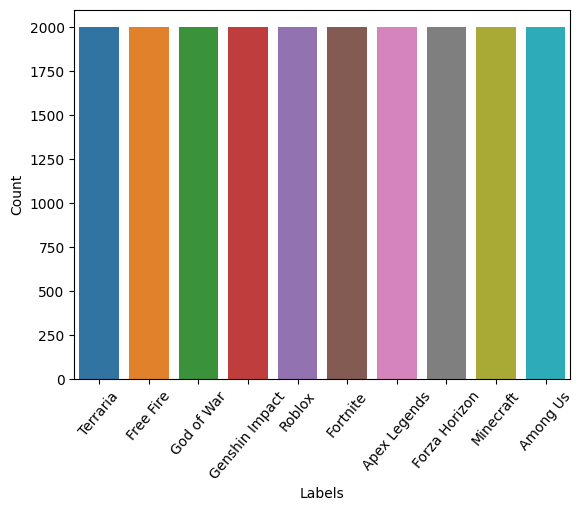

In [ ]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

All data seen to be find and able to use


###images after augmentations

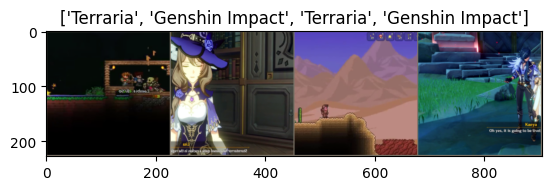

In [ ]:
# Define the imshow function
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause for updating

# Get a batch from the 'train' dataloader
inputs, classes = next(iter(dataloaders['train']))

# Create a grid from the batch
out = torchvision.utils.make_grid(inputs)

# Display the images and their corresponding class labels
imshow(out, title=[class_names[x] for x in classes])

## Computing Error Rate Analysi

The code below is used for error level analysis (ELA) of images in the context of a game image classification task.

In [36]:
# Tensorflow Libraries
from tensorflow import keras
from keras.layers import Dense, Dropout

def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

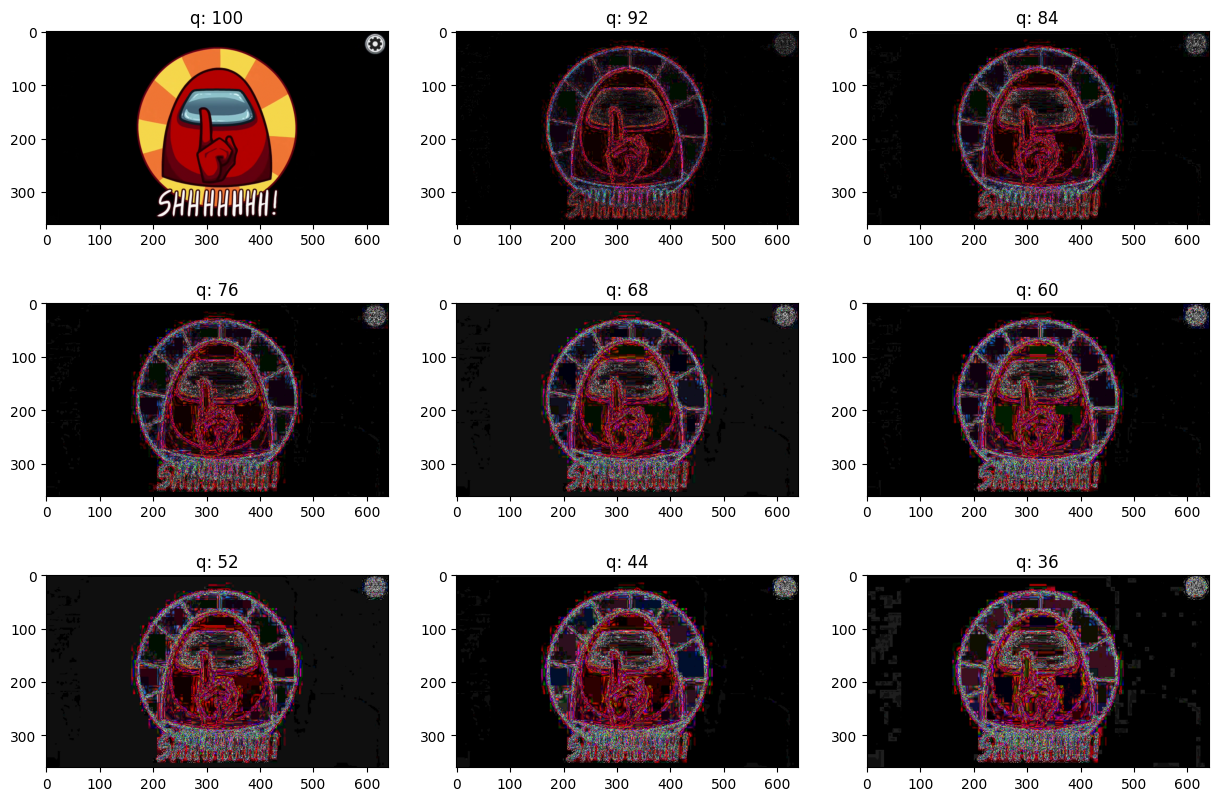

In [37]:
# View random sample from the dataset
p = random_sample('my-dataset/Dataset/Among Us')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

Overall, this code provides a way to visually analyze the effect of different levels of JPEG compression on gaming images, and may be used to identify optimal quality levels for image compression in the context of a animals image classification task.

## Train & Test Split

In [24]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [40]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Games dataset has 13 classes
The Validation Games dataset has 12 classes
The Testing Games dataset has 12 classes


In [41]:
classes_count(train_df, 'Training '+ds_name)

The Training Games dataset has: 

Class 'Genshin Impact' has 789 images
----------------------------------------------------------------------
Class 'Fortnite' has 808 images
----------------------------------------------------------------------
Class 'Terraria' has 796 images
----------------------------------------------------------------------
Class 'Apex Legends' has 794 images
----------------------------------------------------------------------
Class 'Forza Horizon' has 823 images
----------------------------------------------------------------------
Class 'Roblox' has 788 images
----------------------------------------------------------------------
Class 'God of War' has 793 images
----------------------------------------------------------------------
Class 'Free Fire' has 774 images
----------------------------------------------------------------------
Class 'Minecraft' has 830 images
----------------------------------------------------------------------
Class 'Among Us' has 8

In [14]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

## Fuctions

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # There are training and validation phases in each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches of data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass through the model
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation and optimization only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate accuracy and loss for the batch
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Update the learning rate in the training phase
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the best model based on validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f} min {time_elapsed % 60:.0f} sec')
    print(f'Best accuracy on validation: {best_acc:4f}')

    # Load the weights of the best model
    model.load_state_dict(best_model_wts)
    return model


In [30]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [31]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [32]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()

    return history

In [33]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)

    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    return results

In [42]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 8000 validated image filenames belonging to 10 classes.
Found 1199 validated image filenames belonging to 10 classes.
Found 801 validated image filenames belonging to 10 classes.


## Visualizing Model Predictions

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


##Visualize Training dataset

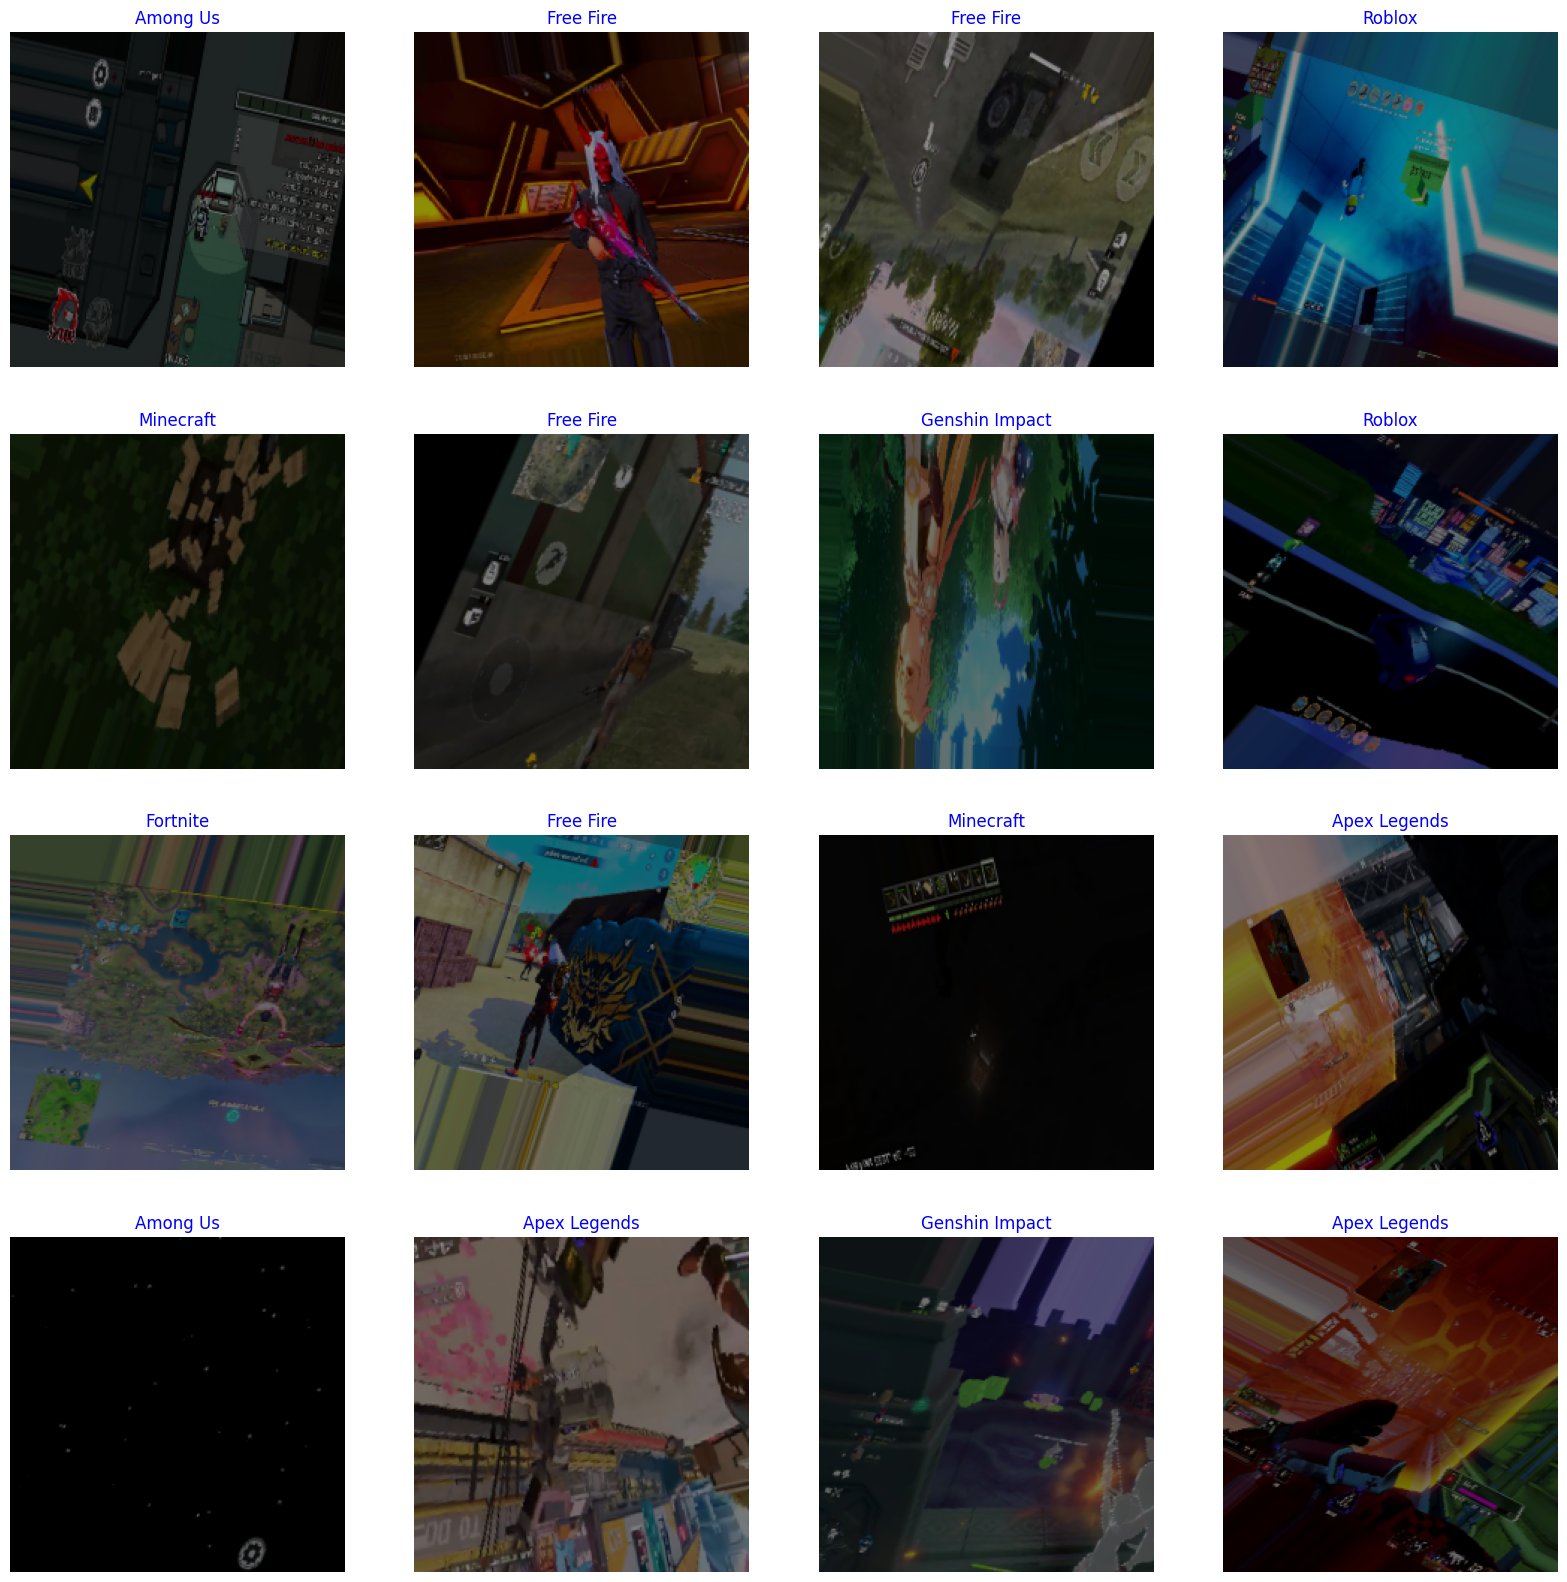

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

## Method 1: Finetuning for Convolutional Networks

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
out_ftrs = len(class_names)
model_ft.fc = nn.Linear(num_ftrs, out_ftrs)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Update weights for the entire model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decrease LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.8MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.8066 Acc: 0.7419
val Loss: 0.1858 Acc: 0.9445

Training complete in 40 min 33 sec
Best accuracy on validation: 0.944500


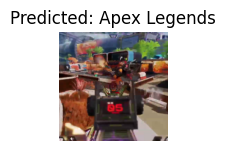

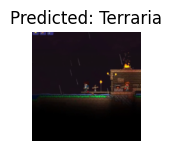

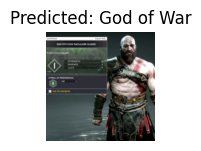

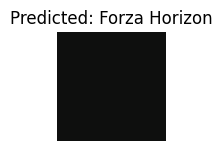

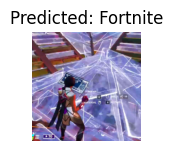

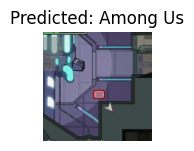

In [ ]:
visualize_model(model_ft)

### Saving model for later use

In [ ]:
import os

# Define the directory where you want to save the model
model_save_dir = 'model'

# Ensure the directory exists
os.makedirs(model_save_dir, exist_ok=True)

# Define the filename for your model
model_filename = 'your_model.pth'

# Combine the directory and filename to create the full model path
model_save_path = os.path.join(model_save_dir, model_filename)

# Save the model's state dictionary
torch.save(model_ft.state_dict(), model_save_path)

# Now your model is saved at model_save_path


In [ ]:

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)


In [ ]:
model_save_path = 'model.pth'

# Save the model's state dictionary
torch.save(model_ft.state_dict(), model_save_path)


### Testing the Acc of Gameplay images classification  

In [ ]:
import torch
from torchvision import transforms

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # Resize and crop as per your model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])




In [ ]:
# Load and preprocess the input image
from PIL import Image
img_path = '/content/Apex-Legends-Mobile_6bwXO9o.webp'
img = Image.open(img_path)
img = preprocess(img)
img = img.unsqueeze(0)  # Add a batch dimension

# Perform inference
model_ft.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model_ft(img)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()

In [ ]:
class_names = ["Minecraft", "Roblox","Among Us", "God of War","Apex Legends","Forza Horizon","Free Fire","Genshin Impact","Terraria"]

predicted_label = class_names[predicted_class]
print(f"Predicted Label: {predicted_label}")


Predicted Label: Apex Legends


## Method 2: Convolutional Network as a Frozen Feature Extractor

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)

# Freeze the parameters
for param in model_conv.parameters():
    param.requires_grad = False

# The new fully connected layer has requires_grad=True by default
num_ftrs = model_conv.fc.in_features
out_ftrs = len(class_names)
model_conv.fc = nn.Linear(num_ftrs, out_ftrs)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Update weights for only the fully connected layer
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decrease LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.8297 Acc: 0.7302
val Loss: 0.2874 Acc: 0.9050

Training complete in 18 min 25 sec
Best accuracy on validation: 0.905000


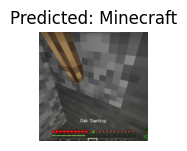

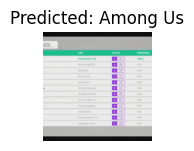

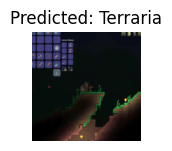

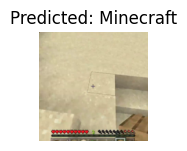

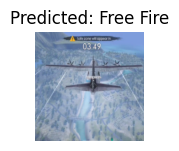

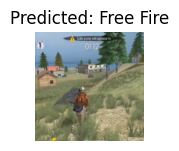

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Saving model

In [ ]:
import os

# Define the directory where you want to save the model
model_save_dir = 'model'

# Ensure the directory exists
os.makedirs(model_save_dir, exist_ok=True)

# Define the filename for your model
model_filename = 'your_model_2.pth'

# Combine the directory and filename to create the full model path
model_save_path = os.path.join(model_save_dir, model_filename)

# Save the model's state dictionary
torch.save(model_conv.state_dict(), model_save_path)

# Now your model is saved at model_save_pat

### Testing model

In [ ]:
# Load and preprocess the input image
from PIL import Image
img_path = '/content/Apex-Legends-Mobile_6bwXO9o.webp'
img = Image.open(img_path)
img = preprocess(img)
img = img.unsqueeze(0)  # Add a batch dimension

# Perform inference
model_conv.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model_conv(img)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()

In [ ]:
class_names = ["Minecraft", "Roblox","Among Us", "God of War","Apex Legends","Forza Horizon","Free Fire","Genshin Impact","Terraria"]

predicted_label = class_names[predicted_class]
print(f"Predicted Label: {predicted_label}")

Predicted Label: Apex Legends


## Method 3: EfficientNetB7

### Method 1

In [ ]:
pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00


In [ ]:
# Import the EfficientNetB7 model from timm library
import timm

# Define the EfficientNetB7 model
model_name = 'tf_efficientnet_b7'
pre_model = timm.create_model(model_name, pretrained=True)

# Adjust the input size for EfficientNetB7
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize((600, 600)),  # Adjust input size for EfficientNetB7
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the number of video game genres (classes)
num_classes = 10  # Update with the number of classes in your dataset

# Modify the model architecture for EfficientNetB7
from torch import nn

pre_model = timm.create_model(model_name, pretrained=True)
pre_model.classifier = nn.Linear(pre_model.classifier.in_features, num_classes)

# Continue with data preprocessing and splitting as in your existing code

# Define the data preprocessing transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(600),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(600),
        transforms.CenterCrop(600),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

In [ ]:

num_epochs = 25
# Define the optimizer and loss function
optimizer = torch.optim.Adam(pre_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
l
model_save_dir = 'model'

# Ensure the directory exists
os.makedirs(model_save_dir, exist_ok=True)

# Define the filename for your model
model_filename = 'efficientnetb7_model.pth'

# Combine the directory and filename to create the full model path
model_save_path = os.path.join(model_save_dir, model_filename)

# Save the model's state dictionary
torch.save(pre_model.state_dict(), model_save_path)



In [ ]:
from PIL import Image
img_path = '/content/Apex-Legends-Mobile_6bwXO9o.webp'  # Replace with the path to your sample image
img = Image.open(img_path)
img = preprocess(img)
img = img.unsqueeze(0)  # Add a batch dimension

# Perform inference
pre_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = pre_model(img)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()

# Define the class names for your dataset
class_names = ["Among Us", "Apex Legends", "Fortnite", "Forza Horizon", "Free Fire", "Genshin Impact", "God of War", "Minecraft", "Roblox", "Terraria"]

# Get the predicted label
predicted_label = class_names[predicted_class]
print(f"Predicted Label: {predicted_label}")

Predicted Label: God of War


### Method 2

Generic Model Creation

In [43]:
import tensorflow as tf
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               327808    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                       

In [44]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               mode='max',
                              )

def step_decay(epoch):

     initial_lrate = 0.1
     drop = 0.5
     epochs_drop = 10.0
     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
     return lrate

lr_scheduler = LearningRateScheduler(step_decay)

Train Model

In [45]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen,
                    validation_steps= None,
                    shuffle= False,
                    batch_size= batch_size)

Epoch 1/10
500/500 [==============================] - 308s 536ms/step - loss: 4.7340 - accuracy: 0.6506 - val_loss: 3.4082 - val_accuracy: 0.8616
Epoch 2/10
500/500 [==============================] - 240s 481ms/step - loss: 3.0303 - accuracy: 0.8037 - val_loss: 2.3198 - val_accuracy: 0.9024
Epoch 3/10
500/500 [==============================] - 240s 481ms/step - loss: 2.1419 - accuracy: 0.8385 - val_loss: 1.6515 - val_accuracy: 0.9058
Epoch 4/10
500/500 [==============================] - 240s 479ms/step - loss: 1.6056 - accuracy: 0.8570 - val_loss: 1.2561 - val_accuracy: 0.9266
Epoch 5/10
500/500 [==============================] - 248s 495ms/step - loss: 1.2968 - accuracy: 0.8700 - val_loss: 1.0549 - val_accuracy: 0.9241
Epoch 6/10
500/500 [==============================] - 251s 501ms/step - loss: 1.1299 - accuracy: 0.8700 - val_loss: 0.9003 - val_accuracy: 0.9349
Epoch 7/10
500/500 [==============================] - 262s 524ms/step - loss: 1.0246 - accuracy: 0.8726 - val_loss: 0.8698 -

Plot accuarcy and loss curve

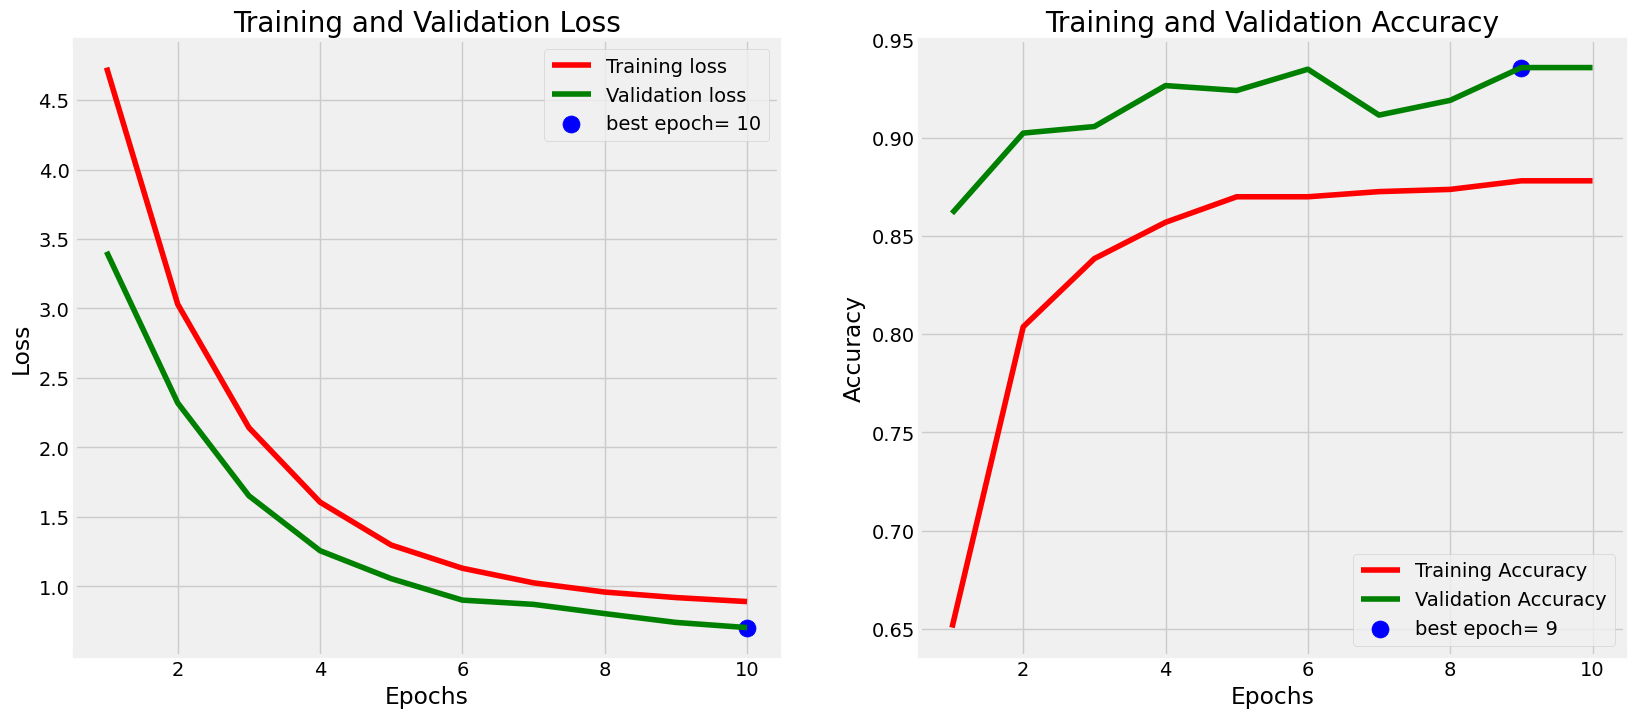

In [46]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Model Accuarcy

In [47]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 [==============================] - 27s 2s/step - loss: 0.7330 - accuracy: 0.9164
Train Loss:  0.6332560181617737
Train Accuracy:  0.9488636255264282
--------------------
Validation Loss:  0.6843981146812439
Validation Accuracy:  0.9488636255264282
--------------------
Test Loss:  0.7330315113067627
Test Accuracy:  0.9163545370101929


In [48]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

Confussion Matrix

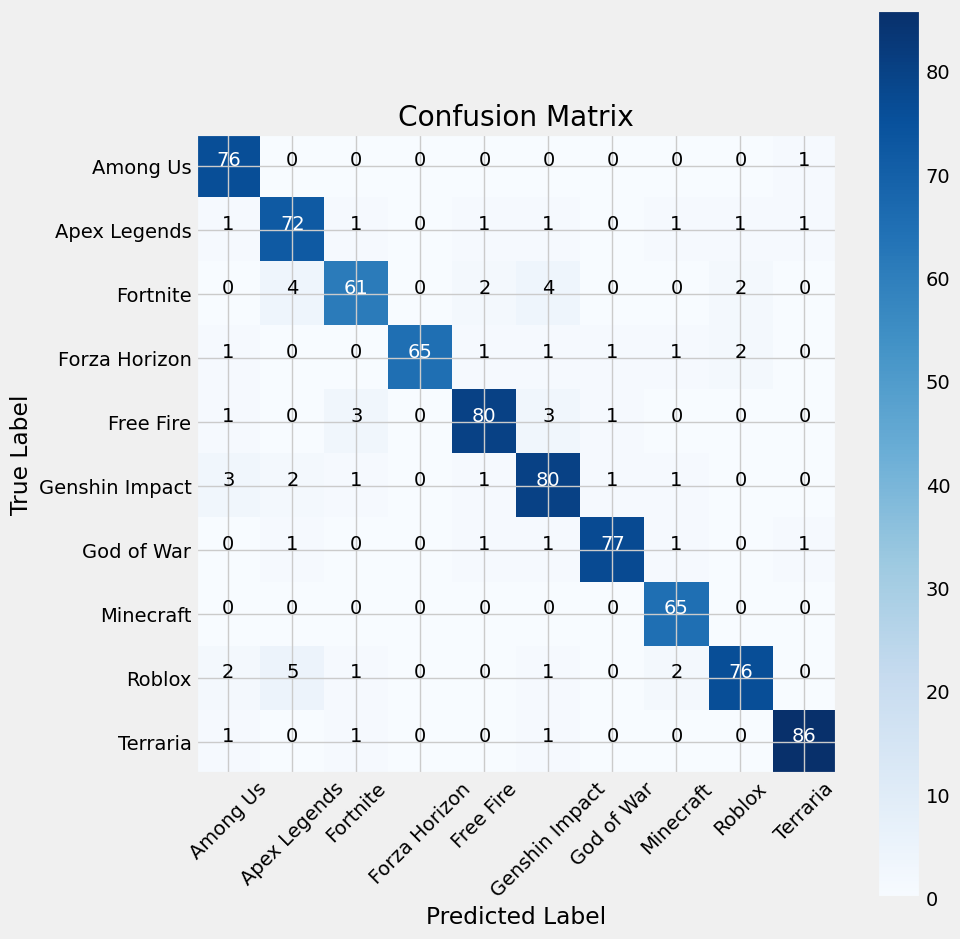

In [49]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [50]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                precision    recall  f1-score   support

      Among Us       0.89      0.99      0.94        77
  Apex Legends       0.86      0.91      0.88        79
      Fortnite       0.90      0.84      0.87        73
 Forza Horizon       1.00      0.90      0.95        72
     Free Fire       0.93      0.91      0.92        88
Genshin Impact       0.87      0.90      0.88        89
    God of War       0.96      0.94      0.95        82
     Minecraft       0.92      1.00      0.96        65
        Roblox       0.94      0.87      0.90        87
      Terraria       0.97      0.97      0.97        89

      accuracy                           0.92       801
     macro avg       0.92      0.92      0.92       801
  weighted avg       0.92      0.92      0.92       801



In [51]:
model.save_weights('my_model_weights.h5')

Load the model and Predict the Inputs

1/1 [==============================] - 7s 7s/step


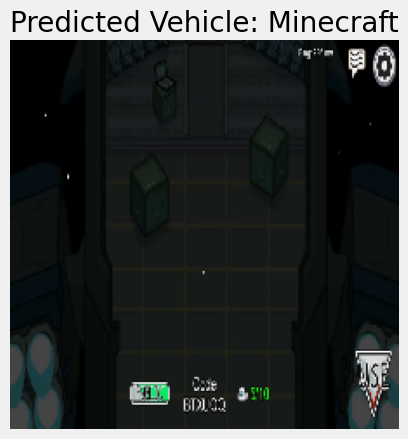

In [52]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Vehicle: {predicted_class_label}")
    plt.show()

# Load your trained model
model.load_weights('my_model_weights.h5')

# Define your class labels (e.g., ['car', 'truck', ...])
class_labels = ["Minecraft", "Roblox","Among Us", "God of War","Apex Legends","Forza Horizon","Free Fire","Genshin Impact","Terraria"]

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = 'my-dataset/Dataset/Among Us/image_0.png'
predict_and_display(image_path_to_test, model, class_labels)

Compare EfficientNet B0 to B7 Results

In [ ]:
# List of EfficientNet models
effnet_models = [EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7]
epochs = 10   # number of all epochs in training

# Loop through each model and train/evaluate
for i, effnet_model in enumerate(effnet_models):
    print(f"Training and evaluating EfficientNet B{i}...")

    base_model = effnet_model(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l=0.016),
              activity_regularizer=tf.keras.regularizers.l1(0.006),
              bias_regularizer=tf.keras.regularizers.l1(0.006), activation='relu'),
        Dropout(rate=0.45, seed=123),
        Dense(class_count, activation='softmax')
    ])

    model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')

    history = model.fit(x=train_gen,
                        epochs=epochs,
                        verbose=0,
                        validation_data=valid_gen,
                        validation_steps=None,
                        shuffle=False,
                        callbacks=[early_stopping])

    print(f"EfficientNet B{i} training completed.")

    # Evaluate the model on the test data
    test_results = model.evaluate(test_gen, verbose=0)
    print(f"Test loss for EfficientNet B{i}: {test_results[0]}")
    print(f"Test accuracy for EfficientNet B{i}: {test_results[1]}")

    # Make predictions on the test data
    y_pred = model.predict(test_gen)
    y_pred_labels = y_pred.argmax(axis=1)
    y_true_labels = test_gen.classes

    # Generate classification report
    report = classification_report(y_true_labels, y_pred_labels, target_names=train_gen.class_indices.keys())
    print(report)
    print("-"*70)

Training and evaluating EfficientNet B0...
EfficientNet B0 training completed.
Test loss for EfficientNet B0: 0.5364596843719482
Test accuracy for EfficientNet B0: 0.9575530290603638
11/11 [==============================] - 20s 2s/step
                precision    recall  f1-score   support

      Among Us       0.96      1.00      0.98        79
  Apex Legends       0.86      0.93      0.89        82
      Fortnite       0.88      0.89      0.88        89
 Forza Horizon       0.93      0.96      0.95        72
     Free Fire       0.94      0.88      0.91        74
Genshin Impact       0.96      0.89      0.92        89
    God of War       0.98      0.97      0.97        88
     Minecraft       0.98      0.98      0.98        64
        Roblox       0.97      0.94      0.95        77
      Terraria       0.96      1.00      0.98        87

      accuracy                           0.94       801
     macro avg       0.94      0.94      0.94       801
  weighted avg       0.94      0.9

In [15]:
# Random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_seed()

In [16]:
# Config device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
CFG = dict(
        batch_size = 16,
        learning_rate = 0.001,
        epochs = 50,
        lin1_size = 128,
        lin2_size = 128,
        activation = 'relu',
        model = 'resnet50'
)

In [18]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.8,1.2), shear=5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ])

In [25]:
train_path = 'my-dataset/Dataset/train'
test_path = 'my-dataset/Dataset/test'

In [27]:
train_dataset = datasets.ImageFolder(train_path, train_transforms)


In [29]:
# Load the ResNet50 model pre-trained on ImageNet
model = models.resnet50(pretrained=True).to(device)
classes = ["Minecraft", "Roblox","Among Us", "God of War","Apex Legends","Forza Horizon","Free Fire","Genshin Impact","Terraria"]

# Freeze the layers of the ResNet50 model
for param in model.parameters():
    param.requires_grad = False

# Add a new classification head to the model
model.fc = nn.Sequential(nn.Linear(2048, CFG['lin1_size']),
                         nn.ReLU(),
                         nn.Linear(CFG['lin2_size'], len(classes))).to(device)

In [30]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters())

# Learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['epochs'])

In [31]:
def train_one_epoch(train_loader, model, criterion, optimizer, scheduler):
    # Train mode
    model.train()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Loop over minibatches
    for inputs, labels in train_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()

        # Update parameters
        optimizer.step()

        # Zero gradients
        optimizer.zero_grad()

        # Track loss
        loss_epoch += loss.detach().item()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    # Update learning rate
    scheduler.step()

    return loss_epoch/len(train_loader), accuracy_epoch.item()/len(train_loader)

In [32]:
def evaluate_one_epoch(test_loader, model, criterion):
    # Eval mode
    model.eval()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Don't update weights
    with torch.no_grad():
        # Loop over minibatches
        for inputs, labels in test_loader:
            # Send to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss
            loss_epoch += loss.detach().item()

            # Accuracy
            _, preds = torch.max(outputs, 1)
            accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    return loss_epoch/len(test_loader), accuracy_epoch.item()/len(test_loader)

In [33]:
# Plot history
def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
pip install wandb


In [38]:
import wandb

def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True):
    # Initialise outputs
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    # Loop over epochs
    for epoch in range(CFG['epochs']):
        # Train
        train_loss, train_accuracy = train_one_epoch(train_loader, model, criterion, optimizer, scheduler)

        # Evaluate
        test_loss, test_accuracy = evaluate_one_epoch(test_loader, model, criterion)

        # Track metrics
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)
        train_acc_hist.append(train_accuracy)
        test_acc_hist.append(test_accuracy)

        # Log metrics
        wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy
        })


        # Print loss
        if verbose:
            if (epoch+1)%1==0:
                print(f'Epoch {epoch+1}/{CFG["epochs"]}, loss {train_loss:.5f}, test_loss {test_loss:.5f}, accuracy {train_accuracy:.5f}, test_accuracy {test_accuracy:.5f}')

    return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

## Model 4: SVM

image Classificaation using SVM is very efficient way of modelling and very rarely used algorithm for image processing and modelling

In [46]:
DATADIR = 'my-dataset/Dataset'
CATEGORIES = ["Minecraft", "Roblox","Among Us", "God of War","Apex Legends","Forza Horizon","Free Fire","Genshin Impact","Terraria"]
IMG_SIZE=100

In [47]:
training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [48]:
lenofimage = len(training_data)

In [49]:
X=[]
y=[]

for categories, label in training_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(lenofimage,-1)
##X = tf.keras.utils.normalize(X, axis = 1)

In [50]:
X.shape

(9000, 30000)

In [51]:
X = X/255.0

In [52]:
y=np.array(y)

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [54]:
from sklearn.svm import SVC
svc = SVC(kernel='linear',gamma='auto')
svc.fit(X_train, y_train)


SVC(gamma='auto', kernel='linear')

In [55]:
y2 = svc.predict(X_test)

In [56]:
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test,y2))


Accuracy on unknown data is 0.972


In [57]:
from sklearn.metrics import classification_report
print("Accuracy on unknown data is",classification_report(y_test,y2))

Accuracy on unknown data is               precision    recall  f1-score   support

           0       0.99      1.00      0.99       253
           1       1.00      1.00      1.00       252
           2       0.98      0.97      0.98       248
           3       0.93      0.91      0.92       250
           4       0.97      0.95      0.96       250
           5       0.91      0.96      0.93       244
           6       0.99      0.99      0.99       239
           7       0.99      0.99      0.99       249
           8       0.99      0.98      0.98       265

    accuracy                           0.97      2250
   macro avg       0.97      0.97      0.97      2250
weighted avg       0.97      0.97      0.97      2250



In [58]:
result = pd.DataFrame({'original' : y_test,'predicted' : y2})
result

original  predicted
0            4          4
1            1          1
2            7          7
3            7          7
4            1          1
...        ...        ...
2245         7          7
2246         1          1
2247         2          2
2248         4          4
2249         5          5

[2250 rows x 2 columns]